In [40]:
# All Imports needed
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
import random
from scipy.spatial.distance import cdist
import matplotlib.image as mpimg

In [41]:
# Reading, Cleaning, and Scaling the data
# read the data
csvdata = pd.read_csv('SoilOrganicCarbonRecovery_NorthwestTerritories.csv')     

# clean the data
csvdata.isnull().sum()                                                         
csvdata.dropna(inplace=True)
csvdata.reset_index(drop=True, inplace=True)

# scale desired data
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "avg_org_carbon", "avg_carbon_stock"]     
data = csvdata[desiredColumns]
for col in desiredColumns:
  maxVal = data[col].max()
  minVal = data[col].min()
  data[col] = (data[col] - minVal) / (maxVal - minVal)


C:\Users\baeza\AppData\Local\Temp\ipykernel_13260\1176048473.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = (data[col] - minVal) / (maxVal - minVal)
C:\Users\baeza\AppData\Local\Temp\ipykernel_13260\1176048473.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = (data[col] - minVal) / (maxVal - minVal)


In [42]:
# All the Functions() needed for cluster creations

def euclideanDistance(point1, point2):
    totalDistance = 0
    for i in range(len(point1)):
        distance = (point1[i] - point2[i])**2
        totalDistance += distance
        
    return np.sqrt(totalDistance)

def getCentroids(data, clusters):
    uniqueClusters = np.unique(clusters)
    centroids = []

    for cluster in uniqueClusters:
        clusterPoints = data[clusters == cluster]
        centroid = np.mean(clusterPoints, axis=0)
        centroids.append(centroid)
        
    return np.array(centroids)

def getTotalWithinClusterVariation(dataWithoutClusters, clusters, centroids):
    totalWithinVariation = 0.0
    clusterCount = len(centroids)

    for i in range(clusterCount):
        clusterPoints = dataWithoutClusters[clusters == i]
        centroid = centroids[i]
        
        distances = [euclideanDistance(point, centroid) for point in clusterPoints]
        withinVariation = np.sum(distances)  
        totalWithinVariation += withinVariation
        
    return totalWithinVariation

def RandomizedHillClimbing(data, epsilons, minPoints, answer):
    for i in range(len(minPoints)):
        model = DBSCAN(eps=epsilons[i], min_samples=minPoints[i])
        model.fit(data)
        modelClusterLabels = model.labels_

        modelCentroids = getCentroids(data, modelClusterLabels)
        modelVariation = getTotalWithinClusterVariation(data.values, modelClusterLabels, modelCentroids)

        modelOutliers = np.count_nonzero(modelClusterLabels == -1)

        if(modelVariation < answer[0] and len(set(modelClusterLabels)) > 2 and modelOutliers <= 134):
            answer[0] = modelVariation
            answer[1] = epsilons[i]
            answer[2] = minPoints[i]
    
    return answer

def plotData3D(dataset, x, y, z):
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(dataset[x], dataset[y], dataset[z], c=dataset['cluster'], cmap='viridis')

  pad=10
  ax.set_xlabel(x, labelpad=pad)
  ax.set_ylabel(y, labelpad=pad)
  ax.set_zlabel(z)
  ax.set_title(f"{x} vs {y} vs {z}", pad=pad)

  plt.show()

def DataSummaries(data, columns):
    answer = pd.DataFrame()
    for col in columns:
        answer[col] = data[col].describe()

    return answer

In [43]:
# Performs the Expierment to find the best overall clusters
desiredColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "avg_org_carbon", "avg_carbon_stock"]
randomEpsilons = [random.random() for _ in range(50)]
randomMinPoints = [random.randint(3,25) for _ in range(50)]

round1 = RandomizedHillClimbing(data[desiredColumns], randomEpsilons, randomMinPoints, [10000, 0, 0])

round2Epsilons = [random.uniform(round1[1]*0.5, round1[1]*1.5) for _ in range(50)]
round2MinPoints = [random.randint(int(round1[2]*0.5),int(round1[2]*1.5)) for _ in range(50)]
round2 = RandomizedHillClimbing(data[desiredColumns], round2Epsilons, round2MinPoints, round1)

round3Epsilons = [random.uniform(round2[1]*0.75, round2[1]*1.25) for _ in range(50)]
round3MinPoints = [random.randint(int(round2[2]*.75),int(round2[2]*1.25)) for _ in range(50)]
round3 = RandomizedHillClimbing(data[desiredColumns], round3Epsilons, round3MinPoints, round2)

newModel = DBSCAN(eps=round3[1], min_samples=round3[2])
newModel.fit(data[desiredColumns])
newmodelClusterLabels = newModel.labels_

newdataWithClusters = pd.concat([data[desiredColumns], pd.Series(newmodelClusterLabels, name="cluster")], axis=1)

Graph for piba_prop_canopy


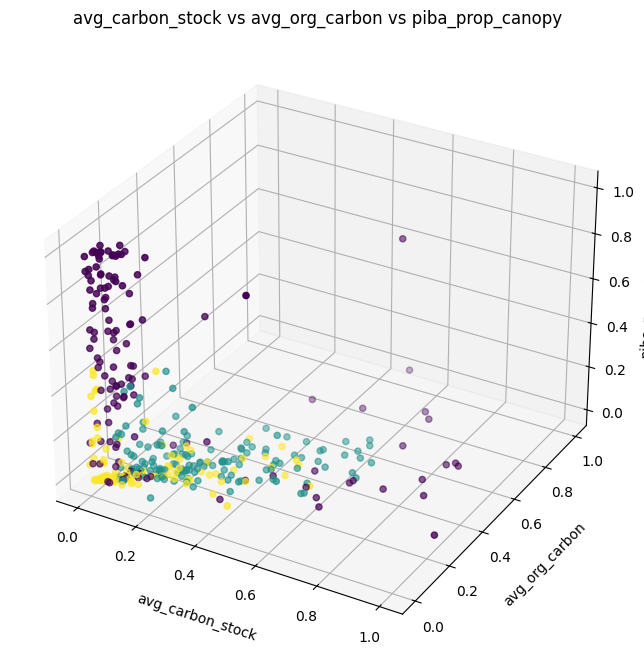

Graph for decid_prop_canopy


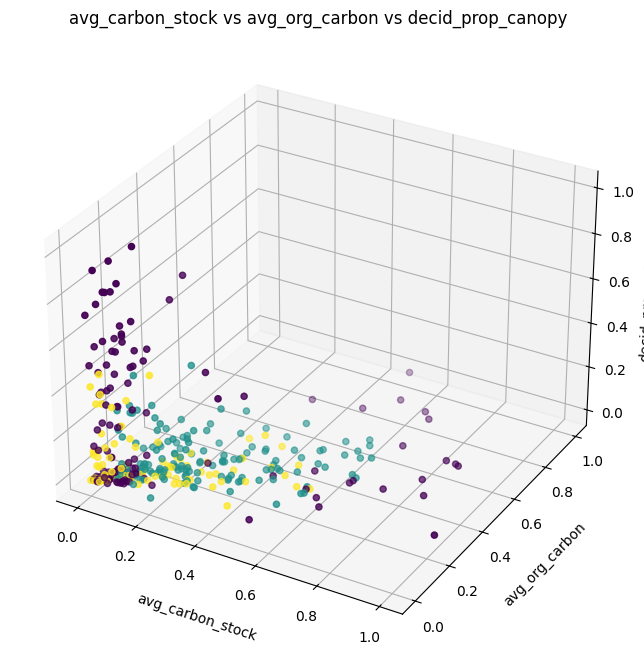

Graph for time_after_fire


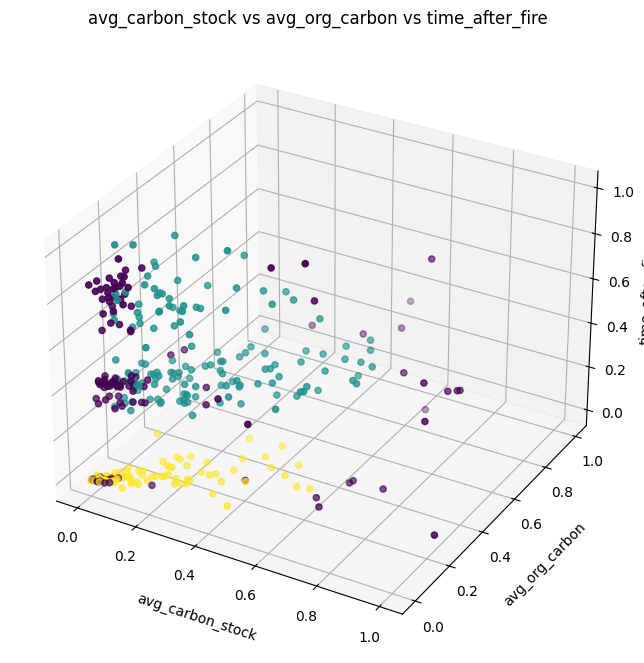

In [44]:
# Plots the Three Graphs to show the Clusters
print("Graph for piba_prop_canopy")
pibaGraph = ["avg_carbon_stock", "avg_org_carbon", "piba_prop_canopy"]
plotData3D(newdataWithClusters, pibaGraph[0], pibaGraph[1], pibaGraph[2])

print("Graph for decid_prop_canopy")
decidGraph = ["avg_carbon_stock", "avg_org_carbon", "decid_prop_canopy"]
plotData3D(newdataWithClusters, decidGraph[0], decidGraph[1], decidGraph[2])


print("Graph for time_after_fire")
timeGraph = ["avg_carbon_stock", "avg_org_carbon", "time_after_fire"]
plotData3D(newdataWithClusters, timeGraph[0], timeGraph[1], timeGraph[2])

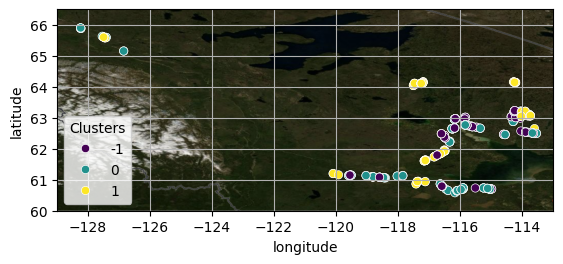

In [45]:
# Outputs Plot of Clusters
locationColumns = ["latitude", "longitude "]
locationData = csvdata[locationColumns]
locationWithClusters = pd.concat([locationData[locationColumns], pd.Series(newmodelClusterLabels, name="cluster")], axis=1)

img = mpimg.imread('No Clouds.png')
plt.imshow(img, extent=[-129, -113, 60, 66.5])  # Set the extent to match the latitude and longitude range

# Plot the data
sns.scatterplot(x='longitude ', y='latitude', hue='cluster', data=locationWithClusters, palette='viridis')

# Add labels and title
plt.ylabel('latitude')
plt.xlabel('longitude')

# Show the plot
plt.legend(title='Clusters')
plt.grid(True)
plt.show()

In [46]:
# Outputs Cluster Averages
orignialDataWithClusters = pd.concat([csvdata, pd.Series(newmodelClusterLabels, name="cluster")], axis=1)

c0Data = orignialDataWithClusters[orignialDataWithClusters['cluster'] == 0]         # cluster 0
c1Data = orignialDataWithClusters[orignialDataWithClusters['cluster'] == 1]         # cluster 1
cOutData = orignialDataWithClusters[orignialDataWithClusters['cluster'] == -1]      # outlier cluster

clusterAverages = pd.DataFrame()
clusterAverages['cluster'] = ["Origninal Data", "Cluster 0", "Cluster 1", "Outliers"]
clusterAverages['count'] = [csvdata["latitude"].count(), c0Data["latitude"].count(), c1Data["latitude"].count(), cOutData["latitude"].count()]

quantColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "avg_org_carbon", "avg_carbon_stock", "latitude", "longitude "]
for col in quantColumns:
    answer = [csvdata[col].mean(), c0Data[col].mean(), c1Data[col].mean(), cOutData[col].mean()]
    clusterAverages[col] = answer

qualiColumns = ["burn", "date", "stand_dominance", "moisture", "nonvascular_functionalgroup", "ecozone"]
for col in qualiColumns:
    answer = [csvdata[col].mode()[0], c0Data[col].mode()[0], c1Data[col].mode()[0], cOutData[col].mode()[0]]
    clusterAverages[col] = answer

clusterAverages

,cluster,count,decid_prop_canopy,piba_prop_canopy,time_after_fire,avg_org_carbon,avg_carbon_stock,latitude,longitude,burn,date,stand_dominance,moisture,nonvascular_functionalgroup,ecozone
0,Origninal Data,372,0.105676,0.198727,36.107527,15.807534,7.719661,62.392718,-116.546020,ZF20,2015-07-12,Black Spruce,Xeric,Lichen,plains
1,Cluster 0,147,0.047687,0.044734,52.625850,21.617479,9.902157,62.099883,-116.883898,F6,2018-07-06,Black Spruce,Hydric,Pleurocarpous,plains
2,Cluster 1,95,0.055975,0.055588,1.189474,10.641930,5.555046,62.926942,-117.201435,ZF20,2015-07-12,Black Spruce,Mesic,Colonizers,plains
3,Outliers,130,0.207569,0.477459,42.946154,13.012692,6.833595,62.333452,-115.685002,CS,2015-07-22,Jack Pine,Xeric,Lichen,shield


In [47]:
# Outputs Cluster Attribute Summaries
clusterSummaries = pd.DataFrame()
rowNames = ['OG min', 'OG 25%', 'OG Avg', 'OG 75%', 'OG max', 'C0 min', 'C0 25%', 'C0 Avg', 'C0 75%', 'C0 max', 'C1 min', 'C1 25%', 'C1 Avg', 'C1 75%', 'C1 max', 'Out min', 'Out 25%', 'Out Avg', 'Out 75%', 'Out max']
clusterSummaries['Row Names'] = rowNames

sumOG = DataSummaries(csvdata, quantColumns)
sumC0 = DataSummaries(c0Data, quantColumns)
sumC1 = DataSummaries(c1Data, quantColumns)
sumOut = DataSummaries(cOutData, quantColumns)

print("\t\tSummary of Original Data")
print(sumOG.to_string())

print("\n\n\t\tSummary of Cluster 0")
print(sumC0.to_string())

print("\n\n\t\tSummary of Cluster 1")
print(sumC1.to_string())

print("\n\n\t\tSummary of Outliers")
print(sumOut.to_string())

		Summary of Original Data
       decid_prop_canopy  piba_prop_canopy  time_after_fire  avg_org_carbon  avg_carbon_stock    latitude  longitude 
count         372.000000        372.000000       372.000000      372.000000        372.000000  372.000000  372.000000
mean            0.105676          0.198727        36.107527       15.807534          7.719661   62.392718 -116.546020
std             0.199444          0.313669        29.462283       15.380294          7.291088    1.281536    2.883050
min             0.000000          0.000000         1.000000        0.450000          0.324503   60.580573 -128.243545
25%             0.000000          0.000000         1.000000        4.737500          2.524156   61.119382 -117.201064
50%             0.000000          0.005284        42.000000       10.900000          4.932712   62.509221 -116.175327
75%             0.116912          0.337155        46.000000       23.250000         10.833987   63.045804 -114.883423
max             0.988764     

In [136]:
def getBarGraph(data, attribute):
    clusterData = data['cluster']
    attributeData = data[attribute]
    columnNames = attributeData.unique()

    c0Frequency = pd.DataFrame(columns=columnNames, data=[[0]*len(columnNames)])
    c1Frequency = pd.DataFrame(columns=columnNames, data=[[0]*len(columnNames)])

    for i in range(len(attributeData)):
        value = attributeData[i]
        if(clusterData[i] == 0):
            c0Frequency.loc[0, value] += 1
        if(clusterData[i] == 1):
            c0Frequency.loc[0, value] += 1
            c1Frequency.loc[0, value] += 1
            
    plt.bar(columnNames, c0Frequency.iloc[0], color='teal', label='Cluster 0')
    plt.bar(columnNames, c1Frequency.iloc[0], color=(1.0, 0.8, 0.0, 1.0), label='Cluster 1')
    
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Frequency')
    plt.title('Frequency of ' + attribute + ' by Cluster')
    plt.legend()
    plt.show()

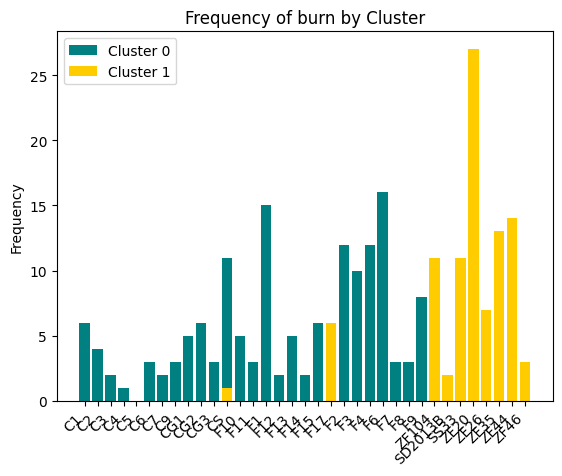

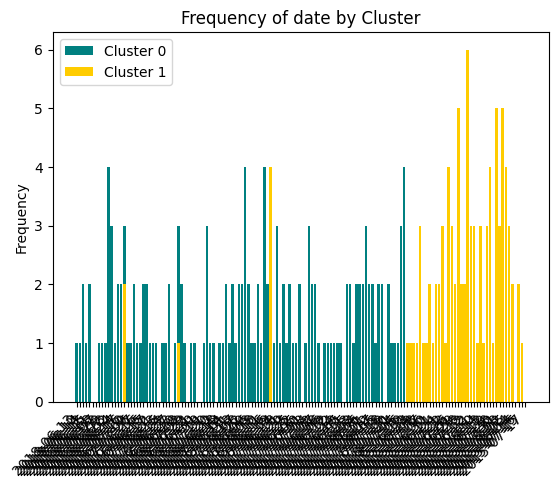

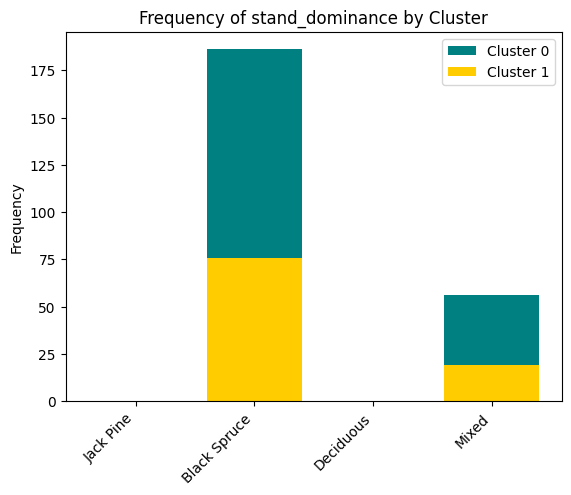

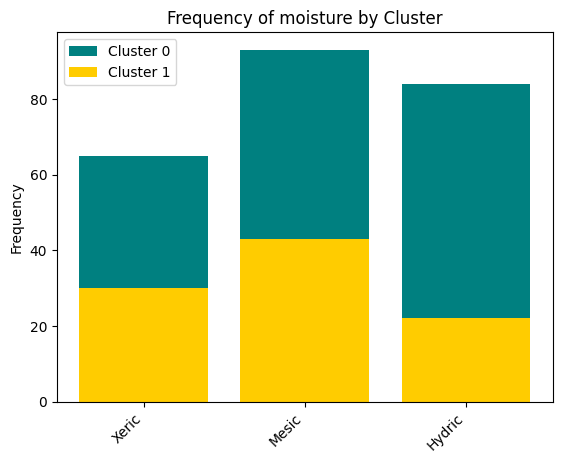

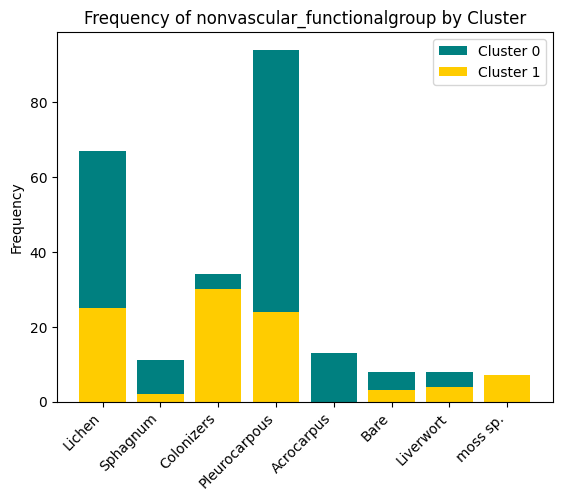

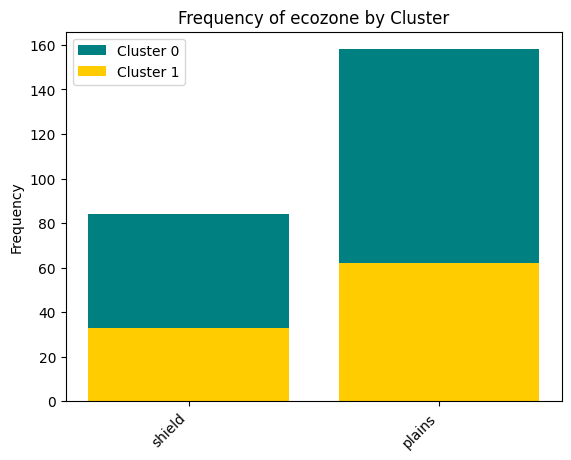

In [137]:
qualiColumns = ["burn", "date", "stand_dominance", "moisture", "nonvascular_functionalgroup", "ecozone"]
for attribute in qualiColumns:
    getBarGraph(orignialDataWithClusters, attribute)

In [130]:
def getDensityPlots(c0Data, c1Data, attribute):
    sns.kdeplot(data=c0Data[attribute], color='teal', fill=True, label='Cluster 0')
    sns.kdeplot(data=c1Data[attribute], color=(1.0, 0.8, 0.0, 1.0), fill=True, label='Cluster 1')

    plt.xlabel(attribute)
    plt.ylabel('Density')
    plt.title('Density of ' + attribute + ' by Cluster')
    plt.legend()
    plt.show()


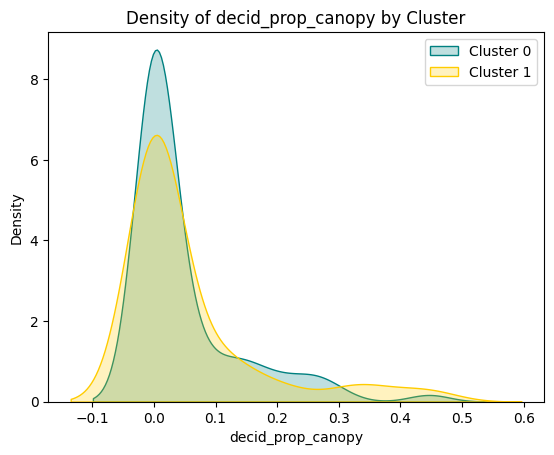

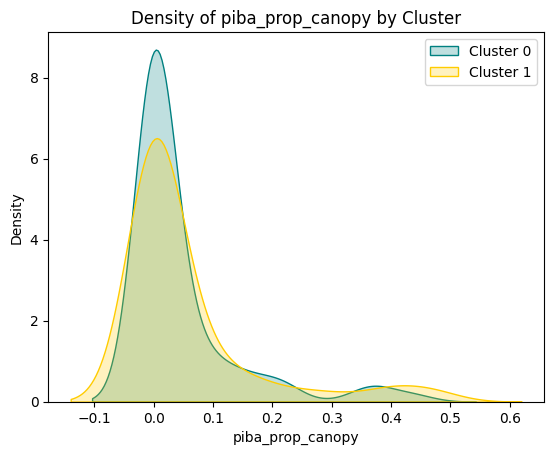

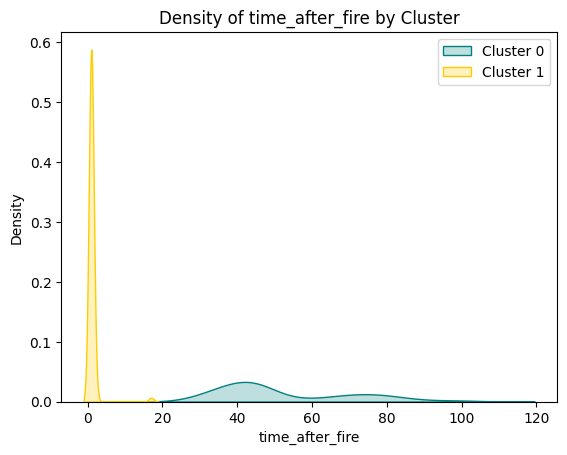

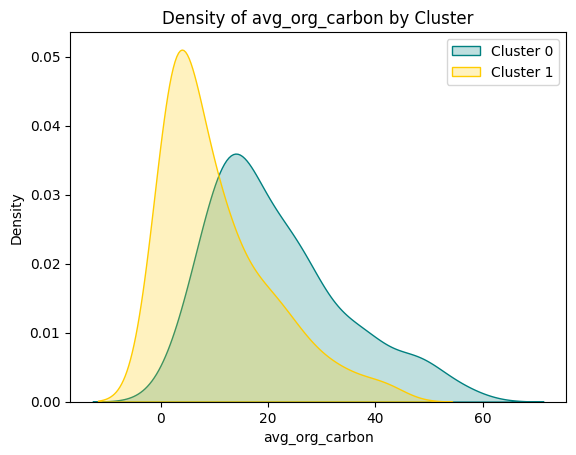

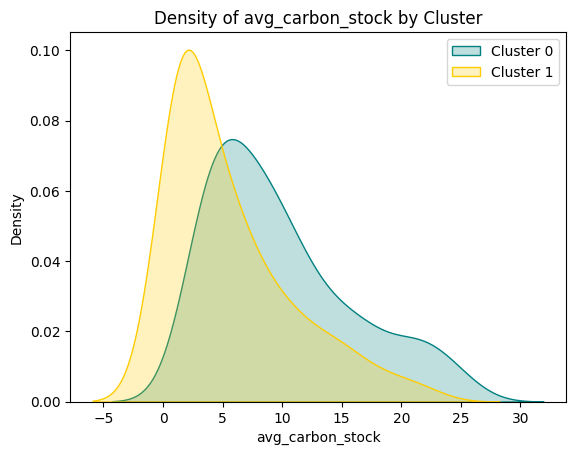

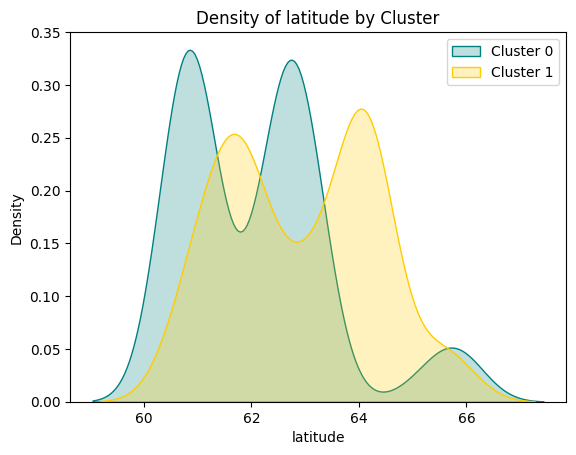

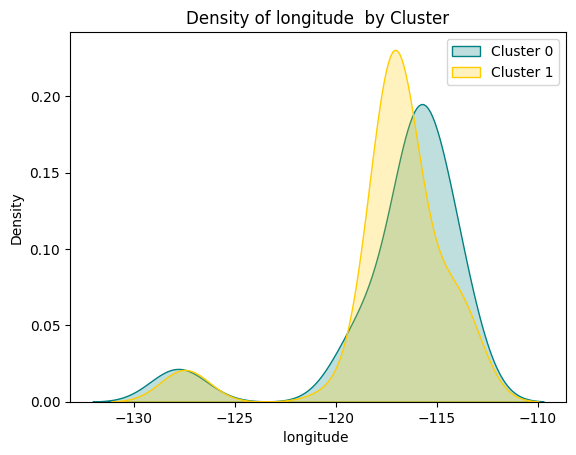

In [131]:
quantColumns = ["decid_prop_canopy", "piba_prop_canopy", "time_after_fire", "avg_org_carbon", "avg_carbon_stock", "latitude", "longitude "]
for attribute in quantColumns:
    getDensityPlots(c0Data, c1Data, cOutData, attribute)